In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

Train_path = r"C:/Users/Disha Patel/OneDrive/Desktop/covid-19 lungs/COVID-19_Lung_CT_Scans"
Augmented_path = r"C:/Users/Disha Patel/OneDrive/Desktop/covid-19 lungs/New folder"
os.makedirs(Augmented_path, exist_ok=True)

In [3]:

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(Train_path):
    class_path = os.path.join(Train_path, class_name)
    save_class_path = os.path.join(Augmented_path, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            img = load_img(img_path)
        except:
            print(f"❌ Skipping corrupted or invalid file: {img_path}")
            continue

        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=save_class_path,
                                  save_prefix="aug",
                                  save_format="jpg"):
            i += 1
            if i >= 5:
                break


❌ Skipping corrupted or invalid file: C:/Users/Disha Patel/OneDrive/Desktop/covid-19 lungs/COVID-19_Lung_CT_Scans\COVID-19\desktop.ini


In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# USE AUGMENTED FOLDER TO TRAIN
train_data = train_datagen.flow_from_directory(
    Augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    Augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 10922 images belonging to 2 classes.
Found 2729 images belonging to 2 classes.


In [29]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_7 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_covid_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)




In [31]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
342/342 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.8430   
Epoch 1: val_loss improved from inf to 27.58830, saving model to best_covid_cnn_model.h5
342/342 [==============================] - 328s 958ms/step - loss: 1.0471 - accuracy: 0.8430 - val_loss: 27.5883 - val_accuracy: 0.2737
Epoch 2/15
342/342 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.9062  
Epoch 2: val_loss improved from 27.58830 to 0.50738, saving model to best_covid_cnn_model.h5
342/342 [==============================] - 320s 936ms/step - loss: 0.3626 - accuracy: 0.9062 - val_loss: 0.5074 - val_accuracy: 0.8787
Epoch 3/15
342/342 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.9120  
Epoch 3: val_loss improved from 0.50738 to 0.27281, saving model to best_covid_cnn_model.h5
342/342 [==============================] - 322s 941ms/step - loss: 0.3394 - accuracy: 0.9120 - val_loss: 0.2728 - val_accuracy: 0.9443
Epoch 4/15
342/342 [=====

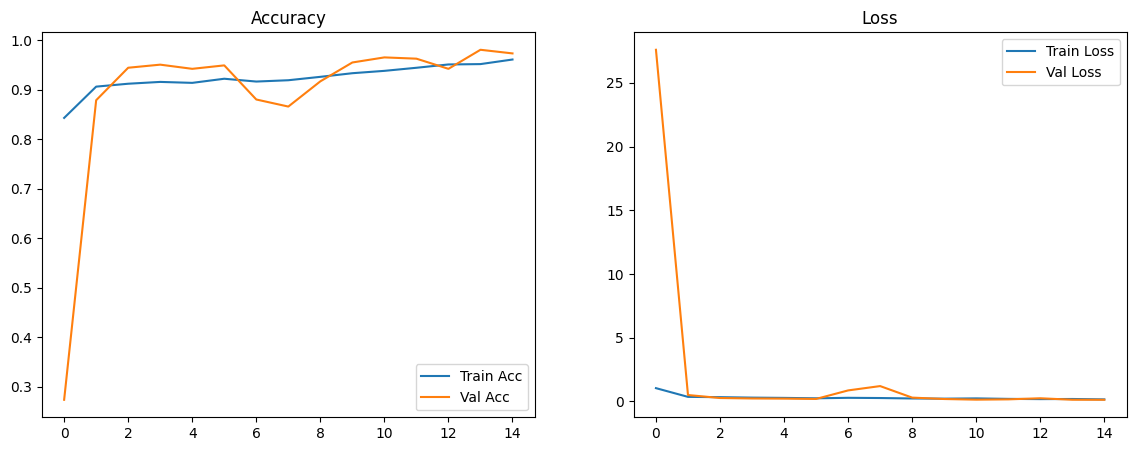

In [32]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

86/86 [==============================] - 17s 191ms/step


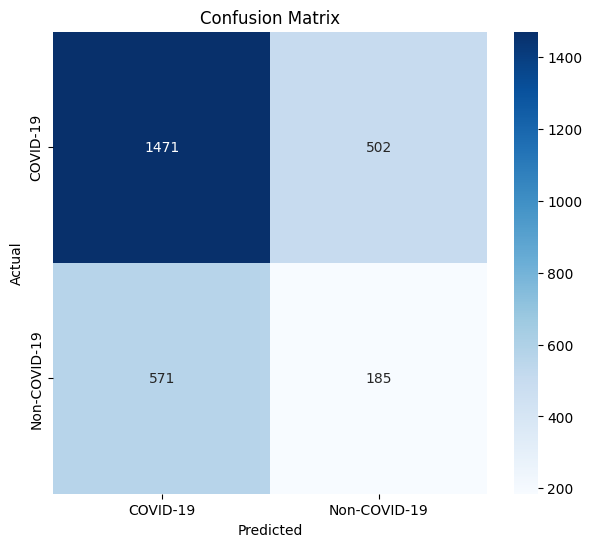

              precision    recall  f1-score   support

    COVID-19       0.72      0.75      0.73      1973
Non-COVID-19       0.27      0.24      0.26       756

    accuracy                           0.61      2729
   macro avg       0.49      0.50      0.49      2729
weighted avg       0.60      0.61      0.60      2729



In [52]:
val_data.reset()
pred = model.predict(val_data)
pred_classes = np.argmax(pred, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_classes, pred_classes, target_names=class_labels))

In [34]:
val_data.reset()  # reset generator
score = model.evaluate(val_data, steps=len(val_data))
print(f"Validation Loss: {score[0]:.4f}")
print(f"Validation Accuracy: {score[1]*100:.2f}%")


86/86 [==============================] - 18s 210ms/step - loss: 0.1346 - accuracy: 0.9733
Validation Loss: 0.1346
Validation Accuracy: 97.33%


In [35]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [36]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(path, model):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    class_label = list(train_data.class_indices.keys())[class_index]
    probability = np.max(pred)

    print("Image:", path)
    print("Prediction:", class_label)
    print("Probability:", probability)

In [37]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0014.png", model)

1/1 [==============================] - 0s 67ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0014.png
Prediction: COVID-19
Probability: 0.997537


In [38]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\103463.webp", model)

1/1 [==============================] - 0s 41ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\103463.webp
Prediction: Non-COVID-19
Probability: 1.0


In [39]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_065.png",model)

1/1 [==============================] - 0s 27ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_065.png
Prediction: Non-COVID-19
Probability: 1.0


In [40]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0111.png",model)

1/1 [==============================] - 0s 33ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0111.png
Prediction: COVID-19
Probability: 1.0


In [41]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\OIP (3).webp",model)

1/1 [==============================] - 0s 35ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\OIP (3).webp
Prediction: Non-COVID-19
Probability: 0.9949767


In [45]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\OIP (1).webp",model)

1/1 [==============================] - 0s 29ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\OIP (1).webp
Prediction: Non-COVID-19
Probability: 1.0


In [47]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0028.png",model)

1/1 [==============================] - 0s 50ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\COVID-19\COVID-19_0028.png
Prediction: COVID-19
Probability: 0.999944


In [48]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_401.png",model)

1/1 [==============================] - 0s 26ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_401.png
Prediction: Non-COVID-19
Probability: 0.9998877


In [49]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_532.png",model)

1/1 [==============================] - 0s 17ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_532.png
Prediction: Non-COVID-19
Probability: 1.0


In [50]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\Non-COVID-19\aug_0_216.jpg",model)

1/1 [==============================] - 0s 28ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\Non-COVID-19\aug_0_216.jpg
Prediction: Non-COVID-19
Probability: 1.0


In [51]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_63.jpg",model)

1/1 [==============================] - 0s 21ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_63.jpg
Prediction: COVID-19
Probability: 1.0


In [53]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_91.jpg",model)

1/1 [==============================] - 0s 36ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_91.jpg
Prediction: COVID-19
Probability: 0.8025493


In [54]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\Non-COVID-19\aug_0_1495.jpg",model)

1/1 [==============================] - 0s 24ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\Non-COVID-19\aug_0_1495.jpg
Prediction: Non-COVID-19
Probability: 0.9176251


In [55]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_337.png",model)

1/1 [==============================] - 0s 22ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\COVID-19_Lung_CT_Scans\Non-COVID-19\Non-COVID-19_337.png
Prediction: Non-COVID-19
Probability: 0.99624664


In [56]:
predict_image(r"C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_63.jpg",model)

1/1 [==============================] - 0s 32ms/step
Image: C:\Users\Disha Patel\OneDrive\Desktop\covid-19 lungs\New folder\COVID-19\aug_0_63.jpg
Prediction: COVID-19
Probability: 1.0


In [57]:
model.save("covid_cnn_model.h5")


In [58]:
import os

print(os.listdir())


['.ipynb_checkpoints', '103463.webp', 'activator.bat', 'adaboost_demo.ipynb', 'best_covid_cnn_improved.h5', 'best_covid_cnn_model.h5', 'best_model_covid.h5', 'big_5b252c1a32b7d.jpg', "BLOCKCHAIN Ma'am NOTES.zip", 'book-recommender-system.ipynb', 'collabera digital.docx', 'covid-19 lungs', 'covid-19-lungs.ipynb', 'covid-19-new.ipynb', 'covid_cnn_model.h5', 'covid_lung_classifier.h5', 'data analyatics.jpg', 'desktop.ini', 'Disha (Your Chrome) - Chrome.lnk', 'disha ins', 'disha ins.zip', 'disha patel(internship).pptx', 'Disha patel(new).pdf', 'disha(report internship) (1).pdf', 'download.webp', 'GitHub Desktop.lnk', 'house_eda.ipynb', 'house_price_eda.ipynb', 'human-activity-smartphine.ipynb', 'images.jpg', 'Indian Patent Details Proforma _CR4D_Parul University(new).docx', 'INS_Project(2203031087049).docx', 'lc26-food-delivery-website-master', 'lc26-food-delivery-website-master.rar', 'lc26-food-delivery-website-master.zip', 'machine learning', 'New folder', 'nlp', 'nlp.ipynb', 'Office 202